In [299]:
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.stattools import acf, pacf
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
%matplotlib inline

In [258]:
### Choose country ###
COUNTRY_REGION = "France"
USE_TIME_SERIES = COUNTRY_REGION == "US" or COUNTRY_REGION.find("US") == -1
# Use time series for US on a country level and other countries
# If the location includes 'US' and it is not US, then use daily reports
# to collect data about US at a state-level

In [259]:
# Replace the following with the directory where you will clone CSSEGISandData's COVID-19 repo #
COVID19_DIR = "/Users/aa5525/Desktop/github/CSSEGISandData/COVID-19/"

DAILY_REPORTS_DIR = COVID19_DIR + "csse_covid_19_data/csse_covid_19_daily_reports"
COUNTRY_LOOKUP_TABLE_CSV = COVID19_DIR + "csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv"

CONFIRMED_TS_CSV = COVID19_DIR + "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
DEATHS_TS_CSV = COVID19_DIR + "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
RECOVERED_TS_CSV = COVID19_DIR + "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"


In [260]:
# Get population
df = pd.read_csv(COUNTRY_LOOKUP_TABLE_CSV)
df = df[df["Combined_Key"] == COUNTRY_REGION]
POPULATION = int(df["Population"].values[0])
print(f"{COUNTRY_REGION}'s population is {POPULATION}")

France's population is 65273512


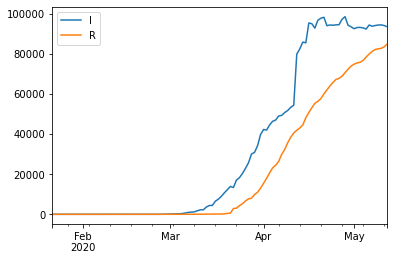

In [261]:
# Read time series
confirmed_ts = pd.read_csv(CONFIRMED_TS_CSV)
deaths_ts = pd.read_csv(DEATHS_TS_CSV)
recovered_ts = pd.read_csv(RECOVERED_TS_CSV)

COUNTRY_COL = "Country/Region" if "Country/Region" in confirmed_ts.columns else "Country_Region"
STATE_COL = "Province/State" if "Province/State" in confirmed_ts.columns else "Province_State"

# helper indexing functions
filter_by_country = lambda ts, name: (ts[COUNTRY_COL].str.find(name) != -1) & ts[STATE_COL].isna()
filter_by_state = lambda ts, name: (ts[STATE_COL] + ", " + ts[COUNTRY_COL]).fillna("").str.find(name) != -1
filter_by_loc = lambda ts, name: filter_by_country(ts, name) | filter_by_state(ts, name)

# Get time series for COUNTRY_REGION only, drop remaining columns
# (and sum all regions in case a region wasn't specified)
drop_cols = [STATE_COL, COUNTRY_COL, "Lat", "Long"]
confirmed_ts = confirmed_ts[filter_by_loc(confirmed_ts, COUNTRY_REGION)].drop(columns=drop_cols).sum()
deaths_ts = deaths_ts[filter_by_loc(deaths_ts, COUNTRY_REGION)].drop(columns=drop_cols).sum()
recovered_ts = recovered_ts[filter_by_loc(recovered_ts, COUNTRY_REGION)].drop(columns=drop_cols).sum()

# Create a Datetime index from one of the above series (we arbitrarily choose confirmed_ts)
time_index = pd.DatetimeIndex(confirmed_ts.index, freq="D")
# Calculate Susceptible, Infectious, and Recovered (including deaths) time series
N = POPULATION
R = recovered_ts + deaths_ts
I = confirmed_ts - R
S = N - I - R
sir_from_ts_file = pd.DataFrame(data=zip(S, I, R),
                                columns=["S", "I", "R"],
                                index=time_index)
sir_from_ts_file[["I", "R"]].plot()

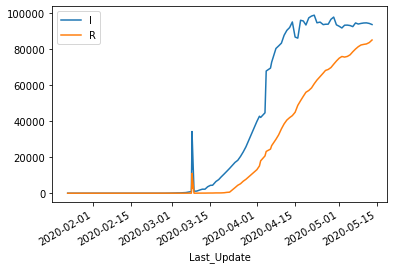

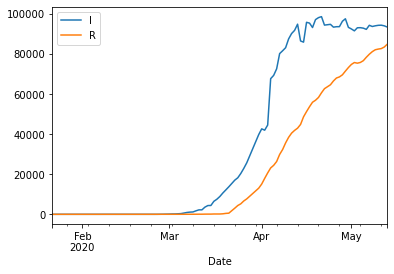

In [262]:
# Helper function that reindexes a dataframe to daily normalized datetimes
def reindex_daily(df, interpolate=None):
    # Remove dates (zero the time component)
    df.index = df.index.normalize()
    # Remove duplicates
    df = df.groupby(df.index).first()
    # Create a daily index that includes all the days in df
    daily_index = pd.DatetimeIndex(pd.date_range(df.index.min(), df.index.max()))
    # Create a new empty data frame similar to df but with the daily index
    daily_df = pd.DataFrame(columns=df.columns, index=daily_index, dtype=np.float64)
    daily_df = daily_df.rename_axis("Date")
    # Copy df's values to daily_df
    daily_df.loc[df.index] = df
    # Interpolate if required
    if interpolate is not None:
        daily_df = daily_df.interpolate(method=interpolate, limit=500, limit_direction="both")
    return daily_df

# The following cells will read from different files
# They will read data from daily reports csv and concatenate them together

# Helper methods for converting old to new format
old_columns = ["Province/State","Country/Region","Last Update","Confirmed","Deaths","Recovered","Latitude","Longitude"]
new_columns = ["FIPS","Admin2","Province_State","Country_Region","Last_Update","Lat","Long_","Confirmed","Deaths","Recovered","Active","Combined_Key"]
old_to_new_col = {
    "Province/State": "Province_State",
    "Country/Region": "Country_Region",
    "Last Update": "Last_Update",
    "Confirmed": "Confirmed",
    "Deaths": "Deaths",
    "Recovered": "Recovered",
    "Latitude": "Lat",
    "Longitude": "Long_",
}
new_to_new_col = {c: c for c in new_columns}
col_map = {**old_to_new_col, **new_to_new_col}

# Extract reports for each day, converting old formats to new ones
dfs = []
for daily_csv in glob.iglob(DAILY_REPORTS_DIR + "/*.csv"):
    df = pd.read_csv(daily_csv)
    # Change columns format to new format adopted from March 22nd
    df.columns = [col_map[col] for col in df.columns]
    # Keep only data related to country of interest
    date = df["Last_Update"].max()
    combined_key = (df["Province_State"] + ", ").fillna("") + df["Country_Region"]
    df = df[combined_key.str.find(COUNTRY_REGION) != -1]
    # Sum all cases containing this country/region
    df = df.sum(numeric_only=True)
    # Weirdly enough, some *daily* reports have multiple dates, so assugn it the latest
    df["Last_Update"] = date
    # Return the indices of interest (note that now the cols became indices because of .sum())
    df = df[["Last_Update", "Confirmed", "Recovered", "Deaths"]]
    dfs.append(df)

# Construct reports df
reports = pd.concat(dfs, axis=1).T.drop_duplicates()
reports.index = pd.DatetimeIndex(reports["Last_Update"])
# Construct SIR df
N = POPULATION
R = reports["Recovered"] + reports["Deaths"]
I = reports["Confirmed"] - R
S = N - I - R
sir_from_daily_reports = pd.DataFrame(data=zip(S, I, R),
                                      columns=["S", "I", "R"],
                                      index=reports.index)
sir_from_daily_reports[["I", "R"]].plot()

# NOTE: There seems to be something wrong with data collected from 2020-03-08 05:31:00
weird_date = pd.to_datetime("2020-03-08 05:31:00")
sir_from_daily_reports = sir_from_daily_reports.drop(weird_date)

# Sort, add daily dates, and interpolate the missing values
sir_from_daily_reports = sir_from_daily_reports.dropna(how="all").sort_index()
sir_from_daily_reports = reindex_daily(sir_from_daily_reports, interpolate="time")
sir_from_daily_reports[["I", "R"]].plot()

In [263]:
######################
 ##### Rates estim ####
  ######################
# Make sure it is daily-indexed and sorted
epi_df = sir_from_ts_file.copy() if USE_TIME_SERIES else sir_from_daily_reports.copy()

In [264]:
# Somewhere around the beginning or March would give good results.
start_date = pd.to_datetime("2020-03-01")
# We should make sure that the starting number of infectious (I) is positive.
epi_df = epi_df[(epi_df.index >= start_date) & (epi_df["I"] > 0)]

epi_df.index[0]

Timestamp('2020-03-01 00:00:00', freq='D')

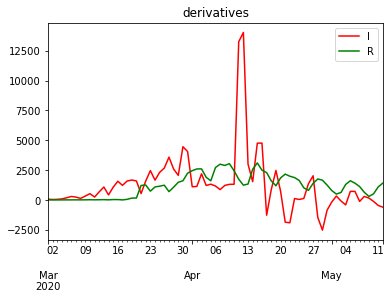

In [265]:
def get_derivative(df):
    dt = df.index.to_series().diff().dt
    dt_in_days = dt.days + dt.seconds / (24 * 60 * 60)
    deriv_df = df.diff().div(dt_in_days, axis="rows")
    return deriv_df

deriv_epi_df = get_derivative(epi_df).shift(-1).rolling(window=2, min_periods=1).mean()
deriv_epi_df[["I", "R"]].plot(color=["r", "g"], title="derivatives")

Mean infection rate last week is: 0.009585380895339543
Mean recovery rate last week is: 0.009824508866018229
Mean R0 last week is: 1.0413796133249706


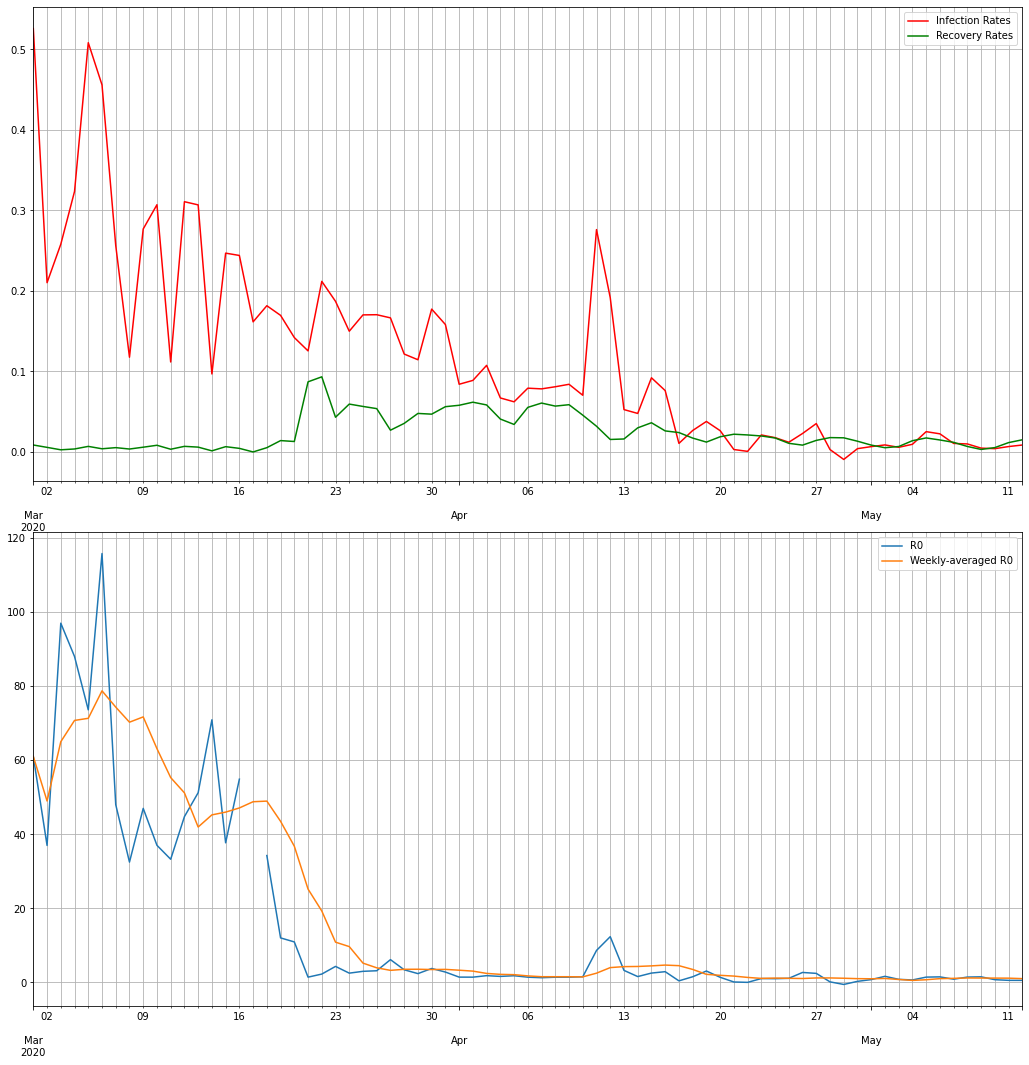

In [266]:
def get_rates(epi_df, deriv_epi_df):
    N = POPULATION
    S, I, R = epi_df["S"], epi_df["I"], epi_df["R"]
    dSdt, dIdt, dRdt = deriv_epi_df["S"], deriv_epi_df["I"], deriv_epi_df["R"]

    # Get the recovery rate (gamma) assuming dR/dt = gamma * I
    recovery_rates = dRdt / I
    # Get the infection rate (beta) assuming dI/dt = beta * (S * I / N) - gamma * I
    infection_rates = (dIdt + dRdt) / (S * I / N)

    # Drop NAs
    infection_rates = infection_rates.replace([np.inf, -np.inf], np.nan).dropna()
    recovery_rates = recovery_rates.replace([np.inf, -np.inf], np.nan).dropna()

    return infection_rates, recovery_rates

# Get infection and recovery rates
infection_rates, recovery_rates = get_rates(epi_df, deriv_epi_df)
# Estimate R0, the basic reproduction number
R0 = infection_rates / recovery_rates

# Plot the beta, gamma, and R0 
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,15))
fig.tight_layout(pad=3.0)
infection_rates.plot(ax=axes[0], color="r", label="Infection Rates")
recovery_rates.plot(ax=axes[0], color="g", label="Recovery Rates")
R0.plot(ax=axes[1], label="R0")
R0.rolling(window=7, min_periods=1).mean().plot(ax=axes[1], label="Weekly-averaged R0")
[(ax.grid(which="both"), ax.legend()) for ax in axes]

print("Mean infection rate last week is:", infection_rates[-7:].mean())
print("Mean recovery rate last week is:", recovery_rates[-7:].mean())
print("Mean R0 last week is:", R0[-7:].mean())

In [267]:
###################
 ##### epi ode ####
  ####################

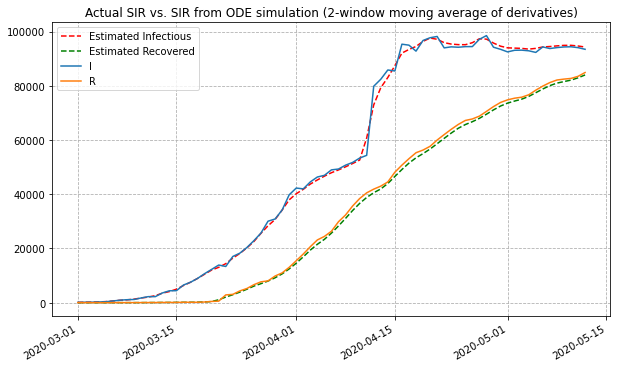

In [545]:
# The SIR model differential equations.
def epi_ode(y, t, N, beta, gamma):
    S, I, R = y
    t = min(round(t), len(beta)-1)
    dSdt = -beta[t] * S * I / N
    dIdt = beta[t] * S * I / N - gamma[t] * I
    dRdt = gamma[t] * I
    return dSdt, dIdt, dRdt

# Initial number of infected and recovered individuals, I0 and R0.
I0 = epi_df["I"][0]
R0 = epi_df["R"][0]
# Total population, N.
N = POPULATION
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Initial condition
y0 = (S0, I0, R0)
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta = infection_rates
gamma = recovery_rates
# A grid of time points (in days)
ts = beta.reset_index().index.values
# Integrate the SIR equations over the time grid, ts.
ys = odeint(epi_ode, y0, ts, args=(N, beta, gamma))
S, I, R = ys.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
ts = beta.index  # reindex time with actual dates
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot()
ax.plot(ts, I, color="r", linestyle="--", label="Estimated Infectious")
ax.plot(ts, R, color="g", linestyle="--", label="Estimated Recovered")
epi_df[["I", "R"]].plot(ax=ax)
ax.grid(linestyle='--')
ax.legend()
plt.title("Actual SIR vs. SIR from ODE simulation (2-window moving average of derivatives)")
plt.show()

1 0.5
2 0.25
3 0.4722222222222222
4 0.6203703703703703
5 0.5216049382716049
6 0.455761316872428
7 0.4996570644718793
8 0.5289208962048468
9 0.5484301173601586
10 0.561436264797033
11 0.5527654998391167
12 0.5469849898671725
13 0.543131316552543
14 0.5457004320956294
15 0.5474131757910202
16 0.5485550049212808
17 0.5477937855011071
18 0.547286305887658
19 0.5469479861453586
20 0.5471735326402248


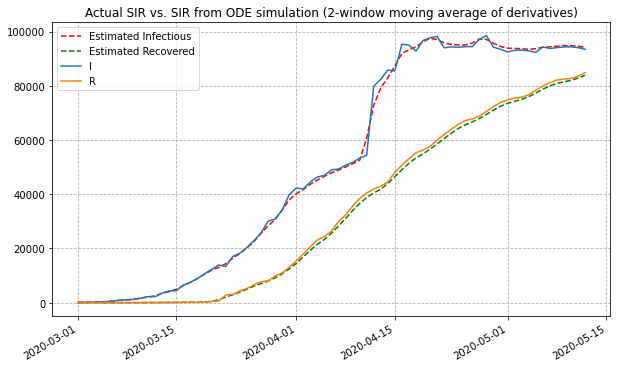

In [546]:
# We smooth the derivatives such that running the integration of the ODE
# would produce the same SIR curve from data
n_iters = 20
lr = 0.5
ewm_alpha_lower, ewm_alpha_upper = (0.25, 0.75)
ewm_alpha = 1.0 # start from the right end
direction = -1
last_error = float("inf")
for i in range(n_iters):
    deriv_epi_df = get_derivative(epi_df).shift(-1).ewm(alpha=ewm_alpha, min_periods=1).mean()

    ### ODE ###
    # Initial condition
    N = POPULATION
    I0, R0 = epi_df["I"][0], epi_df["R"][0]
    S0 = N - I0 - R0
    y0 = (S0, I0, R0)
    # Calculate rates
    infection_rates, recovery_rates = get_rates(epi_df, deriv_epi_df)
    # Get time grid
    ts = infection_rates.reset_index().index.values
    # Integrate the SIR equations over the time grid, ts.
    ys = odeint(epi_ode, y0, ts, args=(N, infection_rates, recovery_rates))
    S, I, R = ys.T
    ### ###

    # Calculate deviation from actual data (we will use I)
    current_error = (epi_df["I"] - I).pow(2).sum() / len(I)
    
    # Fix search direction based if current error is bigger
    if current_error > last_error:
        direction *= -1  # reverse search direction
    
    # Narrow search range based on search direction
    ewm_alpha += direction * lr
    ewm_alpha = min(max(ewm_alpha_lower, ewm_alpha), ewm_alpha_upper)
    print(i+1, ewm_alpha)
    
    # Decay the learning rate
    lr /= 1.5
    last_error = current_error

# Plot the data on three separate curves for S(t), I(t) and R(t)
ts = infection_rates.index  # reindex time with actual dates
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot()
ax.plot(ts, I, color="r", linestyle="--", label="Estimated Infectious")
ax.plot(ts, R, color="g", linestyle="--", label="Estimated Recovered")
epi_df[["I", "R"]].plot(ax=ax)
ax.grid(linestyle='--')
ax.legend()
plt.title("Actual SIR vs. SIR from ODE simulation (Exp weighted moving average of derivatives)")
plt.show()

In [536]:
######################
 ##### Forecasting ####
  ######################
PREDICT = True
if PREDICT:
    # Predict what's gonna happen 4 weeks from now
    validation_days = 0
    forecasting_days = 28
else:
    # Check performance on the last 2 weeks and forecast the next 2 weeks
    validation_days = 14
    forecasting_days = validation_days + 14

use_boxcox = False
EPS = 1e-10

In [1]:
# Create the rates data frame
rates = pd.DataFrame(data=zip(infection_rates, recovery_rates),
                    columns=["infection_rates", "recovery_rates"],
                    index=pd.to_datetime(epi_df.index))
rates = reindex_daily(rates, interpolate="time")
rates.plot(color=["r","g"])

# Keep the last `validation_days` days for validation
last_known_date = epi_df.index[-1] - pd.Timedelta(days=validation_days)
rates = rates[:last_known_date]
last_known_date

NameError: name 'pd' is not defined

In [538]:
rates[rates < 0] = 0
fitted_lambda_I = round(boxcox(rates["infection_rates"] + EPS)[1], 2)
fitted_lambda_R = round(boxcox(rates["recovery_rates"] + EPS)[1], 2)
print("Fitted lambda for infection_rates =", fitted_lambda_I)
print("Fitted lambda for recovery_rates =", fitted_lambda_R)

Fitted lambda for infection_rates = 0.28
Fitted lambda for recovery_rates = 0.18


In [539]:
def power_transform(rates, p, diff=True):
    # Take the power transform
    p_rates = (rates**p - 1)/p if p != 0 else np.log(rates + EPS)
    # Store the inital p_rate (used in the inv_transform)
    t0 = p_rates.index[0]
    p_rates_0 = p_rates.loc[t0]
    # Take the differences (if required)
    if diff:
        p_rates = p_rates.diff()[1:]

    # Define the inverse transformation
    def inv_transform(p_rates, column=None):
        p_rates = p_rates.copy()
        # Take the inverse differences
        if diff:
            # Recover the initial (transformed) rate
            p_rates.loc[t0] = p_rates_0 if column is None else p_rates_0[column]
            # Sort and then cumsum to invert differencing
            p_rates = p_rates.sort_index().cumsum()

        # Invert the power transform
        def relu(x):
            x[x < 0] = 0.0
            return x
        rates = relu(p*p_rates + 1)**(1/p) if p != 0 else np.exp(p_rates)
        
        # Remove negative values
        rates[rates < 0] = 0.0

        return rates

    return p_rates, inv_transform

stationary_rates_I, inv_transform_I = power_transform(rates["infection_rates"], p=fitted_lambda_I)
stationary_rates_R, inv_transform_R = power_transform(rates["recovery_rates"], p=fitted_lambda_R)

# XXX Box-Cox
if use_boxcox:
    stationary_rates_I = pd.Series(boxcox(rates["infection_rates"] + EPS, lmbda=fitted_lambda_I), index=rates.index)
    inv_transform_I = lambda r: inv_boxcox(r, fitted_lambda_I)
    stationary_rates_R = pd.Series(boxcox(rates["recovery_rates"] + EPS, lmbda=fitted_lambda_R), index=rates.index)
    inv_transform_R = lambda r: inv_boxcox(r, fitted_lambda_R)

# Check if the inv_transform is correct
error_I = (inv_transform_I(stationary_rates_I) - rates["infection_rates"]).abs()
error_R = (inv_transform_R(stationary_rates_R) - rates["recovery_rates"]).abs()
assert (error_I < EPS**0.5).all().all()
assert (error_R < EPS**0.5).all().all()

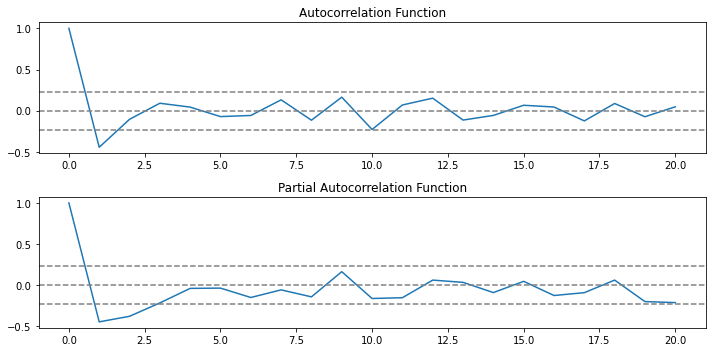

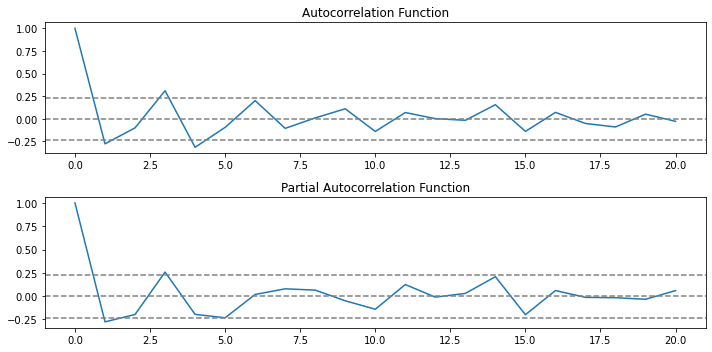

In [540]:
def plot_ACF_PACF(series):
    lag_acf = acf(series, nlags=20, fft=False)
    lag_pacf = pacf(series, nlags=20, method='ols')
    #Plot ACF:
    fig = plt.figure(figsize=(10,5))
    plt.subplot(211)
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(series)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(series)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')
    #Plot PACF:
    plt.subplot(212)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(series)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(series)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()
    
    return lag_acf, lag_pacf


_ = plot_ACF_PACF(stationary_rates_I)
_ = plot_ACF_PACF(stationary_rates_R)

/Users/aa5525/opt/miniconda3/envs/epi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Ellipsis

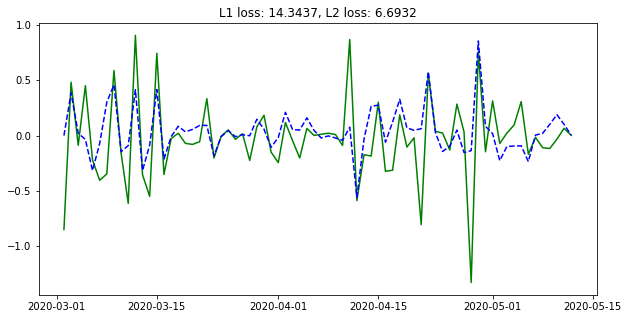

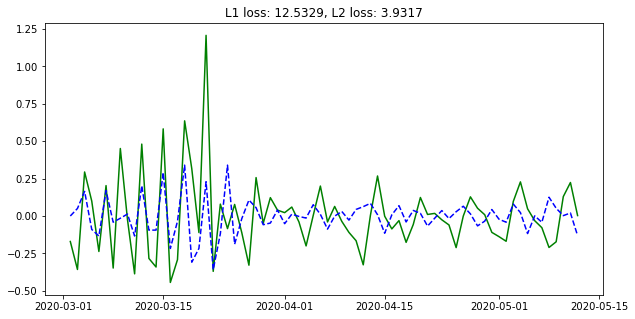

In [541]:
def get_forecaster(series, forecasting_method=SimpleExpSmoothing, forecasting_options={}, fitting_options={}):
    # Fit model
    model = forecasting_method(series, **forecasting_options)
    fitted_model = model.fit(**fitting_options)

    # Plot actual series and forecasted series
    plt.figure(figsize=(10,5))
    plt.plot(series, color="g")
    plt.plot(fitted_model.fittedvalues, color='b', linestyle="--")
    l1_loss = (series - fitted_model.fittedvalues).abs().values.sum()
    l2_loss = (series - fitted_model.fittedvalues).pow(2).values.sum()
    plt.title(f"L1 loss: {l1_loss:.4f}, L2 loss: {l2_loss:.4f}")
    
    return fitted_model

# NOTE: ARIMA's order should be tweaked as necessary
#       depending on the autocorrelations in the series
ARIMA_options = {
    "forecasting_method": ARIMA,
    "forecasting_options": {"order": (3,0,3)},
}
dates = rates[rates.index <= last_known_date].index
weeks = round((dates.max() - dates.min()).days / 7)
SARIMAX_options = {
    "forecasting_method": SARIMAX,
    "forecasting_options": {
        "order": (2,0,2),
        "seasonal_order": (0,0,2, 3*weeks)
    },
}
VARMAX_options = {
    "forecasting_method": VARMAX,
    "forecasting_options": {"order": (3,3)},
}

SES_options = {
    "forecasting_method": SimpleExpSmoothing,
}
ES_options = {
    "forecasting_method": ExponentialSmoothing,
    "forecasting_options": {
        "trend": "add",
        "damped": True,
        #"seasonal": "mul",
        #"seasonal_periods": 7,
    },
    "fitting_options": {
        "use_boxcox": "log",
        "remove_bias": True,
        "use_basinhopping": True,
        "use_brute": True,
    },
}

# Use SARIMAX
forecaster_I = get_forecaster(stationary_rates_I, **SARIMAX_options)
forecaster_R = get_forecaster(stationary_rates_R, **SARIMAX_options)


#################################
### Experiemental stuff below ###
#################################

# Use Exponential Smoothing
"""
forecaster_I = get_forecaster(rates["infection_rates"], **ES_options)
forecaster_R = get_forecaster(rates["recovery_rates"], **ES_options)
inv_transform_I = inv_transform_R = lambda x: x
"""

# Use VARMAX
"""
forecasters = get_forecaster(rates, **VARMAX_options)
rates_fcast = rates.copy().append(forecasters.forecast(forecasting_days))
ts = rates_fcast.index
ts_future = ts[ts >= last_known_date]
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot()
rates.plot(ax=ax, color=["r", "g"], label=["Infection Rates", "Recovery Rates"])
rates_fcast.loc[ts_future].plot(ax=ax, color=["r", "g"], linestyle="--")
ax.axvline(x=last_known_date, color="grey")
ax.legend()
plt.title("Rates Forecasting for " + COUNTRY_REGION)
plt.show()
"""

...

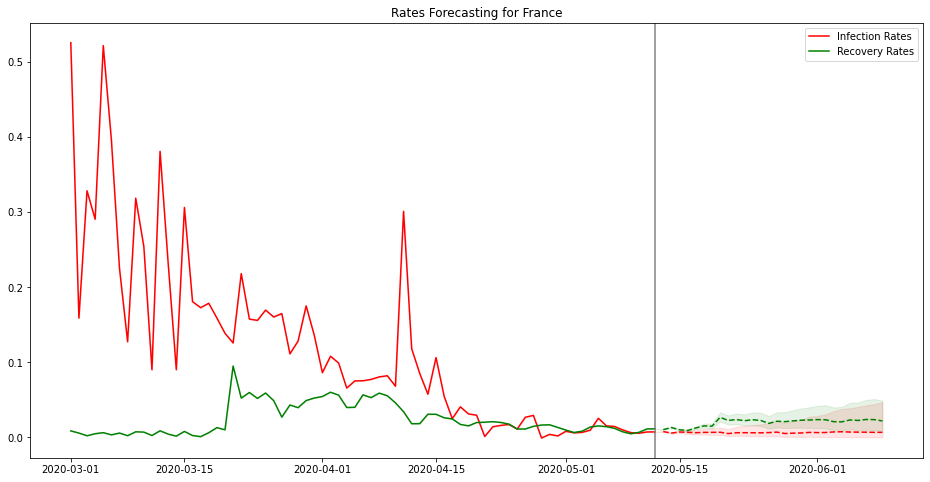

In [542]:
def add_forecast(series, forecaster, days=forecasting_days, conf_int=None, alpha=0.9):
    assert conf_int is None or conf_int in ("lower", "upper")
    if conf_int is None:
        forecast = forecaster.forecast(days)
    else:
        forecast = forecaster.get_forecast(days).conf_int(alpha=alpha)
        forecast = forecast.iloc[:, 0 if conf_int == "lower" else 1]
        assert forecast.name.find(conf_int) != -1
    return series.append(forecast)


# Get forecast means and confidence intervals
alpha = 0.95
infection_rates_fcast    = add_forecast(stationary_rates_I, forecaster_I)
infection_rates_fcastlow = add_forecast(stationary_rates_I, forecaster_I, conf_int="lower", alpha=alpha)
infection_rates_fcastup  = add_forecast(stationary_rates_I, forecaster_I, conf_int="upper", alpha=alpha)
recovery_rates_fcast     = add_forecast(stationary_rates_R, forecaster_R)
recovery_rates_fcastlow  = add_forecast(stationary_rates_R, forecaster_R, conf_int="lower", alpha=alpha)
recovery_rates_fcastup   = add_forecast(stationary_rates_R, forecaster_R, conf_int="upper", alpha=alpha)
# Inverse transform the forecasts
infection_rates_fcast    = inv_transform_I(infection_rates_fcast)
infection_rates_fcastlow = inv_transform_I(infection_rates_fcastlow)
infection_rates_fcastup  = inv_transform_I(infection_rates_fcastup)
recovery_rates_fcast     = inv_transform_R(recovery_rates_fcast)
recovery_rates_fcastlow  = inv_transform_R(recovery_rates_fcastlow)
recovery_rates_fcastup   = inv_transform_R(recovery_rates_fcastup)

# Plot forecasted rates
ts = infection_rates_fcast.index
ts_future = ts[ts > last_known_date]
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot()
#infection_rates.plot(ax=ax, color="r", label="infection rates", legend=True)
#recovery_rates.plot(ax=ax, color="g", label="recovery_rates", legend=True)
ax.plot(infection_rates.index, infection_rates, color="r", label="Infection Rates")
ax.plot(recovery_rates.index, recovery_rates, color="g", label="Recovery Rates")
ax.plot(ts_future, infection_rates_fcast[ts_future], color="r", linestyle="--")
ax.plot(ts_future, recovery_rates_fcast[ts_future], color="g", linestyle="--")
ax.fill_between(ts, infection_rates_fcastlow, infection_rates_fcastup, color="r", alpha=.1)
ax.fill_between(ts, recovery_rates_fcastlow, recovery_rates_fcastup, color="g", alpha=.1)
ax.axvline(x=last_known_date, color="grey")
ax.legend()
plt.title("Rates Forecasting for " + COUNTRY_REGION)
plt.savefig(f"{COUNTRY_REGION} - Rates Forecast Example (with{'out' if PREDICT else ''} validation).png")
plt.show()

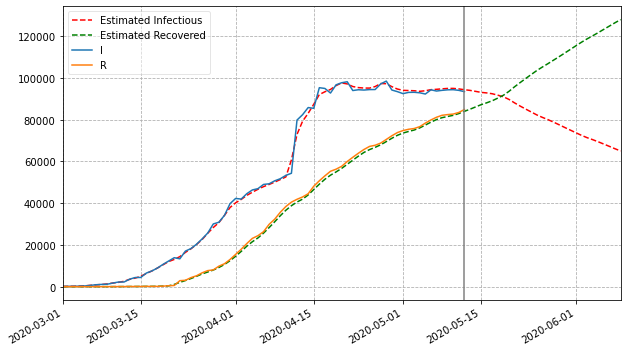

In [543]:
# Initial number of infected and recovered individuals, I0 and R0.
I0 = epi_df["I"][0]
R0 = epi_df["R"][0]
# Total population, N.
N = POPULATION
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Initial condition
y0 = (S0, I0, R0)
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta = infection_rates_fcast
gamma = recovery_rates_fcast
# A grid of time points (in days)
ts = beta.reset_index().index.values
# Integrate the SIR equations over the time grid, ts.
ys = odeint(epi_ode, y0, ts, args=(N, beta, gamma))
S, I, R = ys.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
ts = beta.index  # reindex time with actual dates
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot()
ax.plot(ts, I, "r", label="Estimated Infectious", linestyle="--")
ax.plot(ts, R, "g", label="Estimated Recovered", linestyle="--")
epi_df[["I", "R"]].plot(ax=ax)
ax.set_xlim(ts[0], ts[-1])
ax.axvline(x=last_known_date, color="grey")
ax.grid(linestyle="--")
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.show()

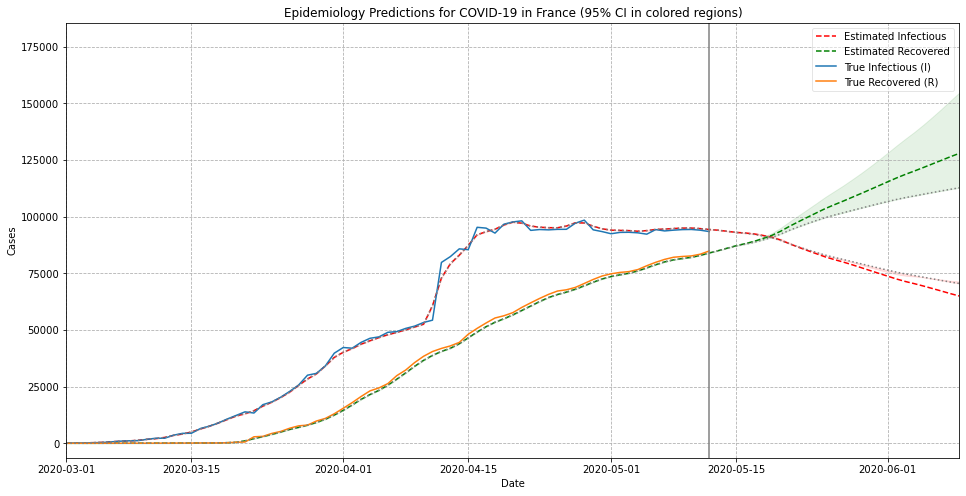

In [544]:
### This cell is similar to the one above except that
### it runs the ode for lower and upper limits of the confidence
### interval of the rates, and colors the regions between them.

# Initial number of infected and recovered individuals, I0 and R0.
I0 = epi_df["I"][0]
R0 = epi_df["R"][0]
# Total population, N.
N = POPULATION
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Initial condition
y0 = (S0, I0, R0)

# A grid of time points (in days)
ts = beta.reset_index().index.values
beta_lower  = infection_rates_fcastlow
beta_upper  = infection_rates_fcastup
gamma_lower = recovery_rates_fcastlow
gamma_upper = recovery_rates_fcastup

# Integrate the SIR equations over the time grid, ts.
S_lower, I_lower, R_lower = odeint(epi_ode, y0, ts, args=(N, beta_lower, gamma_lower)).T
S_upper, I_upper, R_upper = odeint(epi_ode, y0, ts, args=(N, beta_upper, gamma_upper)).T

# Plot the data on three separate curves for S(t), I(t) and R(t)
ts = beta.index
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot()
ax.plot(ts, I, "r", label="Estimated Infectious", linestyle="--")
ax.plot(ts, R, "g", label="Estimated Recovered", linestyle="--")
ax.plot(epi_df.index, epi_df["I"], label="True Infectious (I)")
ax.plot(epi_df.index, epi_df["R"], label="True Recovered (R)")
ax.axvline(x=last_known_date, color="grey")
ax.fill_between(ts, I_lower, I_upper, color="r", alpha=.1)
ax.fill_between(ts, R_lower, R_upper, color="g", alpha=.1)
ax.plot(ts, I_lower, "grey", linestyle=":")
ax.plot(ts, R_lower, "grey", linestyle=":")
ax.set_xlim(ts[0], ts[-1])
ax.set_ylim(max(max(I), max(R))*-0.05, max(max(I), max(R))*1.45)
ax.grid(linestyle="--")
ax.legend().get_frame().set_alpha(0.5)
ax.set_title(f"Epidemiology Predictions for COVID-19 in {COUNTRY_REGION} "
             f"({int(alpha*100)}% CI in colored regions)")
ax.set_xlabel("Date")
ax.set_ylabel("Cases")
fcast_opt = SARIMAX_options["forecasting_options"]
fcast_order = (*fcast_opt["order"], *fcast_opt["seasonal_order"])
forecaster_name = "SARIMAX(" + ','.join(map(str, fcast_order)) + ")"
plt.savefig(f"{COUNTRY_REGION} - {forecaster_name} (v={validation_days}, f={forecasting_days}).png")
plt.show()

In [245]:
########################
 ##### Curve fitting ####
  ########################
# Curve fitting is tricky to tune
# You should come up with the equation of a curve that you believe
# will be a good fit for the change of infection/recovery rates

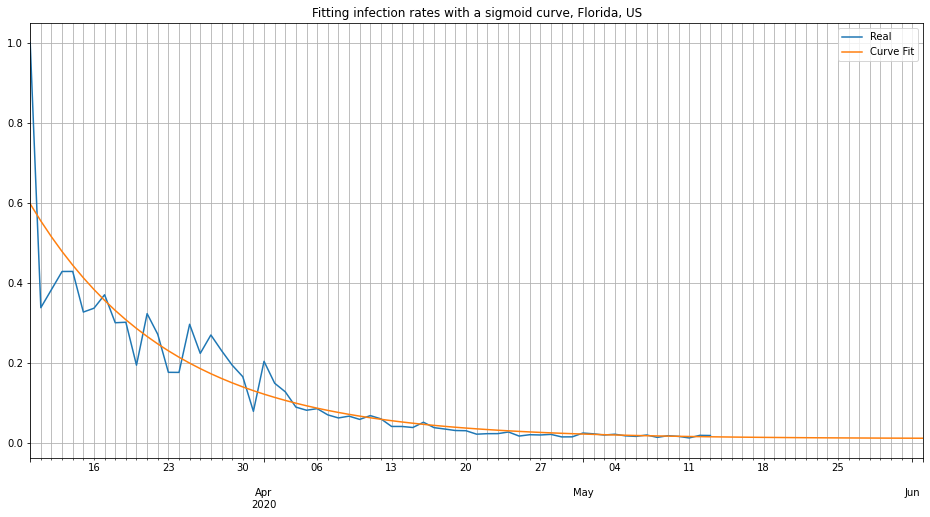

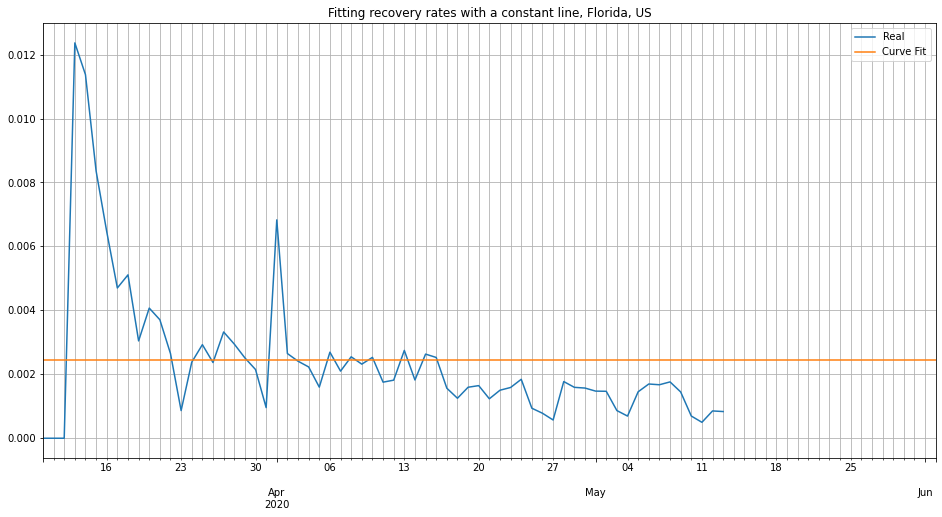

In [246]:
def curvefit_extrapolate(series, func, guess, forecast_days=20, return_curve=False):
    
    series = series.copy()

    # Curve fit each column
    x = series.reset_index().index.astype(float)
    y = series.values
    params = curve_fit(func, x, y, guess, maxfev=10000)
    
    def fitted_curve(x):
        return func(x, *params[0])

    # Extend date index for forecasting
    last_known_date = len(series) - 1
    extended_dates = pd.date_range(series.index.min(),
                                   series.index.max() + pd.Timedelta(days=forecast_days))
    series = pd.Series(data=series, index=extended_dates)  #pd.DatetimeIndex(extended_dates)

    # Calculate the fitted curve for all points
    x = series.reset_index().index.astype(float)
    func_series = pd.Series(data=fitted_curve(x), index=extended_dates)
    
    # Plot the real data and the fitted curve
    series[:last_known_date+1].plot(label="Real", legend=True)
    func_series.plot(label="Curve Fit", legend=True)

    # Extrapolate (or replace) with the fitted function
    if return_curve:
        series = func_series
    else:
        x_extra = series.reset_index().index[last_known_date+1:].astype(float)
        series[last_known_date+1:] = fitted_curve(x_extra)
    
    return series


# Functions to curve fit to the data
def poly_decay(x, c_exp, c0, *c):
    poly = sum(map(lambda n: c[n] * x**n, range(len(c))))
    return c0 + poly * np.exp(c_exp * x)

def sigmoid(x, c_0, c_1, c_2, c_3):
    return c_0 + c_1 / (1 + np.exp(c_2 - c_3 * x))

def line(x, c_0, c_1):
    return c_0 + c_1 * x

def constant(x, c):
    return c

poly_decay_guess = (-0.5, 0.1, *[0.5]*6)
sigmoid_guess = (0.1, 0.5, 30.0, 1.0)

fig = plt.figure(figsize=(16,8))
plt.title("Fitting infection rates with a sigmoid curve, " + COUNTRY_REGION)
beta_predict = curvefit_extrapolate(infection_rates, sigmoid, sigmoid_guess, return_curve=True)
plt.grid(which="both")
plt.savefig(f"{COUNTRY_REGION} - Infection Rates Curve.png")

fig = plt.figure(figsize=(16,8))
plt.title("Fitting recovery rates with a constant line, " + COUNTRY_REGION)
gamma_predict = curvefit_extrapolate(recovery_rates, constant, (0.0125,), return_curve=True)
plt.grid(which="both")
plt.savefig(f"{COUNTRY_REGION} - Recovery Rates Curve.png")

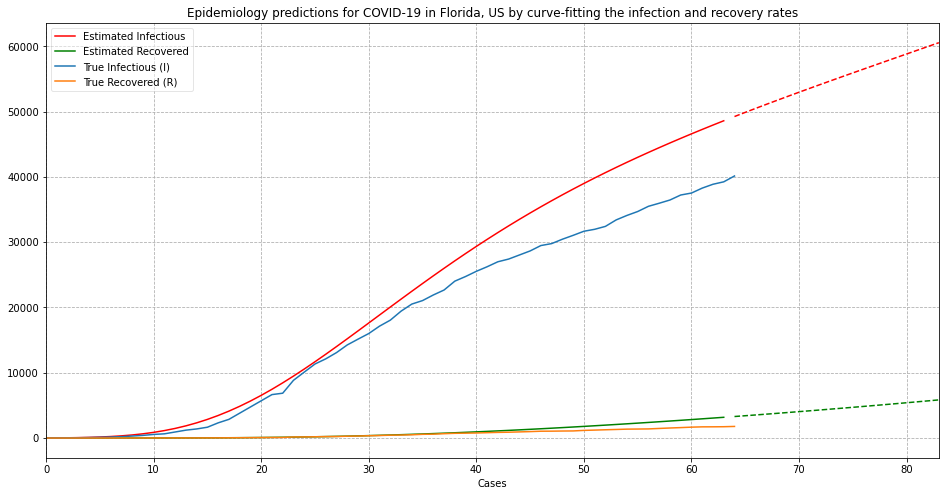

In [247]:
# Initial number of infected and recovered individuals, I0 and R0.
start_date = infection_rates.index[0]
last_date = infection_rates.index[-1]
I0 = epi_df["I"][start_date]
R0 = epi_df["R"][start_date]
# Total population, N.
N = POPULATION
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta = beta_predict[start_date:]
gamma = gamma_predict[start_date:]
# A grid of time points (in days)
ts = beta.reset_index().index.values[:-1]
# Initial condition
y0 = (S0, I0, R0)
# Integrate the SIR equations over the time grid, ts.
ys = odeint(epi_ode, y0, ts, args=(N, beta, gamma))
S, I, R = ys.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot()
known_days = (last_date - start_date).days
plt.title(f"Epidemiology predictions for COVID-19 in {COUNTRY_REGION} by curve-fitting the infection and recovery rates")
ax.plot(ts[:known_days], I[:known_days], "r", label="Estimated Infectious")
ax.plot(ts[:known_days], R[:known_days], "g", label="Estimated Recovered")
ax.plot(ts[known_days:], I[known_days:], "r", linestyle="--")
ax.plot(ts[known_days:], R[known_days:], "g", linestyle="--")
ax.plot(ts[:known_days+1], epi_df["I"], label="True Infectious (I)")
ax.plot(ts[:known_days+1], epi_df["R"], label="True Recovered (R)")
ax.set_xlim(ts[0], ts[-1])
plt.xlabel("Time (in days)")
plt.xlabel("Cases")
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
ax.grid(linestyle="--")
plt.savefig(f"{COUNTRY_REGION} - Epidemiology with Curve-Fitting the Rates.png")
plt.show()